## Блокнот для инференса раскрашивания симпсонов

запускаем тут функции и оцениваем результат

In [ ]:
# моделька лежит тут https://drive.google.com/file/d/1qFGHs2lpasOflpr8-MZsOsWFzAEYgV4S/view?usp=sharing

In [1]:
# импорт нужных библиотек

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [7]:
# ЗАГРУЗКА ИЗОБРАЖЕНИЙ

# приделаем гугл драйв, туда хорошо бы заранее положить модель и картинки для инференса, наприрмер - датасет с симсонами, тестовую папку
# моделька лежит тут https://drive.google.com/file/d/1qFGHs2lpasOflpr8-MZsOsWFzAEYgV4S/view?usp=sharing

import PIL
print(PIL.__version__)
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip
!ls train

9.4.0
Mounted at /content/gdrive/
simpsons_dataset


In [2]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
# создадим класс для изображений, возвращающих само изображение и его черно-белую копию

class SimpsonPix(Dataset):
    def __init__(self, files):
        self.files = sorted(files)

    def __len__(self):
        return len(self.files)

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        target_image = np.array(self.load_sample(self.files[index]))
        input_image = target_image

        target_transform = A.Compose(
            [A.Resize(width=256, height=256),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
             ToTensorV2()]
            )

        input_transform = A.Compose(
            [A.Resize(width=256, height=256),
             A.ToGray(p=1),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
             ToTensorV2()]
            )

        target_image = target_transform(image=target_image)["image"]
        input_image = input_transform(image=input_image)["image"]

        return input_image, target_image

In [69]:
from pathlib import Path
TEST_DIR = Path('./testset')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# ГЕНЕРАТОР

class GeneratorPix(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(                                      # in 256*256*3 out ...
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.enc_conv1 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv2 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv3 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv4 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv5 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )
        self.enc_conv6 =nn.Sequential(                                                   #  out
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.5),
        )

        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), #  out
            nn.ReLU(),
        )

        self.dec_conv0 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.dec_conv1 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.dec_conv2 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.dec_conv3 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv4 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512*2, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv5 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv6 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(0.5),
        )
        self.dec_conv7 =nn.Sequential(                                                   #  out
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            #nn.Dropout(0.5),
        )

    def forward(self, x):
        d1 = self.enc_conv0(x)
        d2 = self.enc_conv1(d1)
        d3 = self.enc_conv2(d2)
        d4 = self.enc_conv3(d3)
        d5 = self.enc_conv4(d4)
        d6 = self.enc_conv5(d5)
        d7 = self.enc_conv6(d6)
        bottleneck = self.bottleneck_conv(d7)
        up1 = self.dec_conv0(bottleneck)
        up2 = self.dec_conv1(torch.cat([up1, d7], 1))
        up3 = self.dec_conv2(torch.cat([up2, d6], 1))
        up4 = self.dec_conv3(torch.cat([up3, d5], 1))
        up5 = self.dec_conv4(torch.cat([up4, d4], 1))
        up6 = self.dec_conv5(torch.cat([up5, d3], 1)) # up5 512
        up7 = self.dec_conv6(torch.cat([up6, d2], 1))
        up8 = self.dec_conv7(torch.cat([up7, d1], 1))
        return up8


In [11]:
dataset_test = SimpsonPix(test_files)
val_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [12]:
gen = GeneratorPix().to(device)
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [13]:
model_load_gen_50 =  GeneratorPix()
optimizer_load_gen_50 = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint_50 = torch.load('/content/gdrive/MyDrive/GeneratorPix2.pth')
model_load_gen_50.load_state_dict(checkpoint_50['model_state_dict'])
optimizer_load_gen_50.load_state_dict(checkpoint_50['optimizer_state_dict'])
epoch_50 = checkpoint_50['epoch']

In [58]:
# функция которая сохраняет картинки возвращает тензоры нормализованные после генерации

# итератор
iterator=iter(val_loader)

def save_some_examples_and_return_some_tensoers (gen, iterator, epoch, folder):
    x, y = next(iterator)
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake_1 = gen(x)
        y_fake = y_fake_1 * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

    x_mother = y
    save_image (x_mother * 0.5 + 0.5, folder + f"/input_mother_{epoch}.png")
    return x, y_fake_1, x_mother

In [26]:
import matplotlib.pyplot as plt

In [56]:
# функция которая рисует картинки

def show_some_exampless (image):
    image.cpu()
    image = image * 0.5 + 0.5  # remove normalization

    plt.imshow((torch.squeeze(image).cpu()).permute(1, 2, 0))


In [59]:
d1, d2, d3 = save_some_examples_and_return_some_tensoers (model_load_gen_50.to(device), iterator, epoch=50, folder='/content/gdrive/MyDrive/')

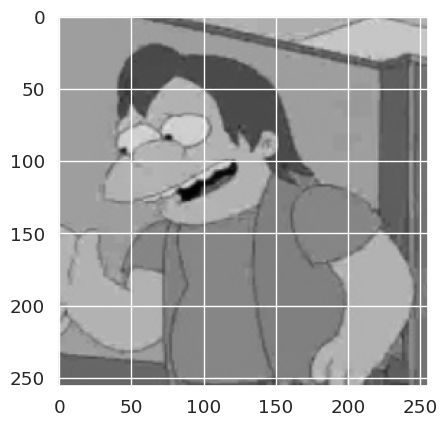

In [60]:
show_some_exampless(d1) # идет в генерацию

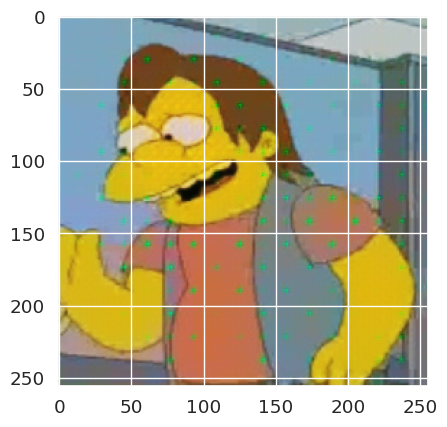

In [61]:
show_some_exampless(d2) # сгенерированные

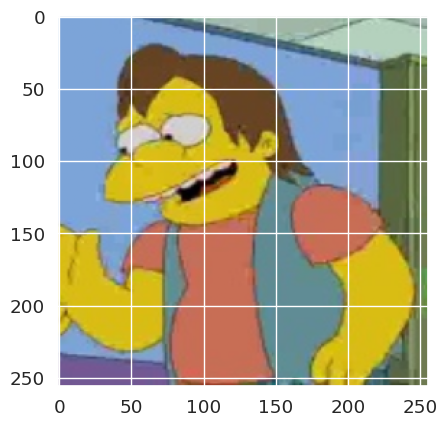

In [62]:
show_some_exampless(d3) # из датасета с измененными размерами

In [64]:
c1, c2, c3 = save_some_examples_and_return_some_tensoers (model_load_gen_50.to(device), iterator, epoch=50, folder='/content/gdrive/MyDrive/')

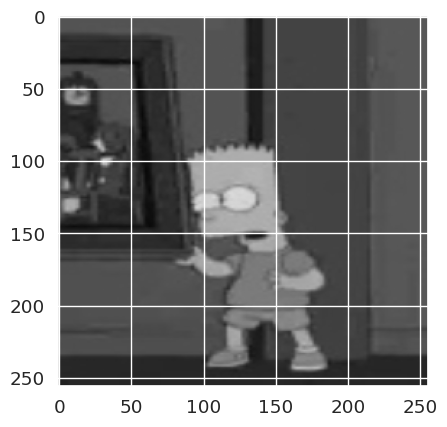

In [65]:
show_some_exampless(c1) # идет в генерацию

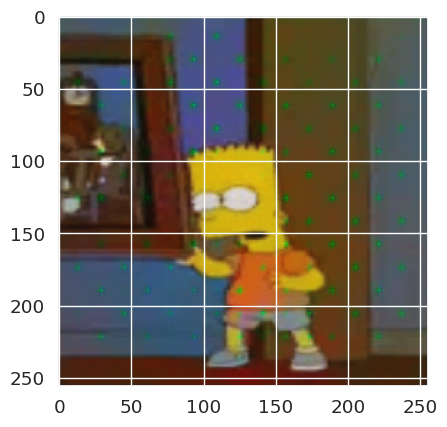

In [66]:
show_some_exampless(c2) # сгенерированные

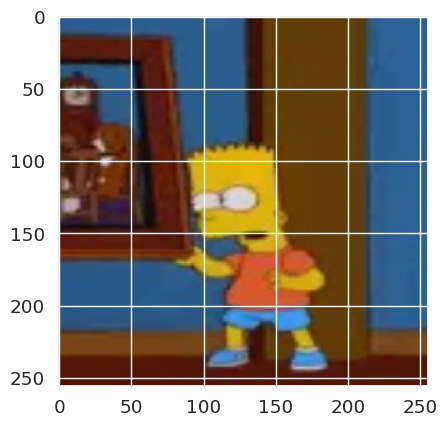

In [67]:
show_some_exampless(c3) # из датасета с измененными размерами

In [74]:
# можно побробовать на доругом изображении похожей стилистики например из футурамы

# сделаем папочку с изображениями и укажем к ним путь

TEST_DIR_futurama = Path('/content/gdrive/MyDrive/Futurama/')
test_files_futurama = sorted(list(TEST_DIR_futurama.rglob('*.jpg')))

In [75]:
dataset_futurama = SimpsonPix(test_files_futurama)
futurama_loader = DataLoader(dataset_futurama, batch_size=1, shuffle=False)

In [76]:
# итератор futurama
iterator_futurama=iter(futurama_loader)

In [78]:
f1, f2, f3 = save_some_examples_and_return_some_tensoers (model_load_gen_50.to(device), iterator_futurama, epoch=105, folder='/content/gdrive/MyDrive/')

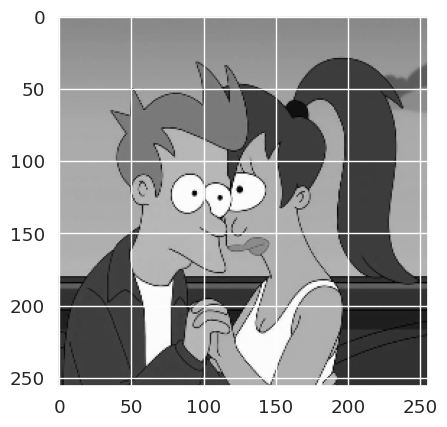

In [79]:
show_some_exampless(f1) # идет в генерацию

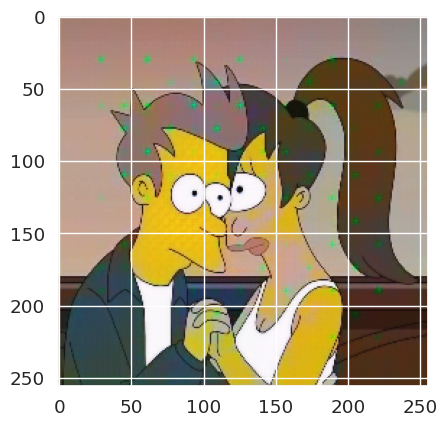

In [80]:
show_some_exampless(f2) # сгенерированные

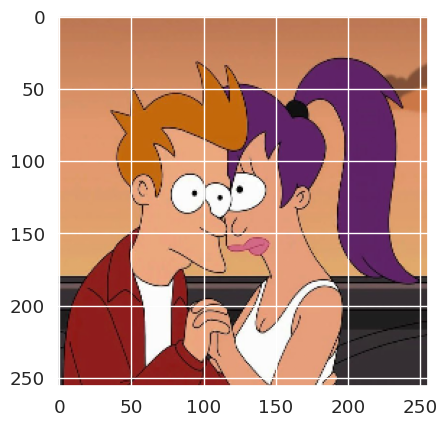

In [81]:
show_some_exampless(f3) # из датасета с измененными размерами

In [82]:
ff1, ff2, ff3 = save_some_examples_and_return_some_tensoers (model_load_gen_50.to(device), iterator_futurama, epoch=205, folder='/content/gdrive/MyDrive/')

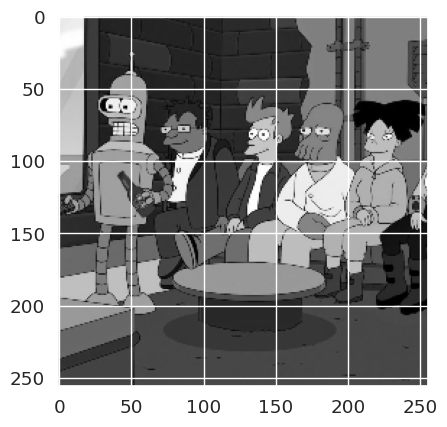

In [83]:
show_some_exampless(ff1) # идет в генерацию

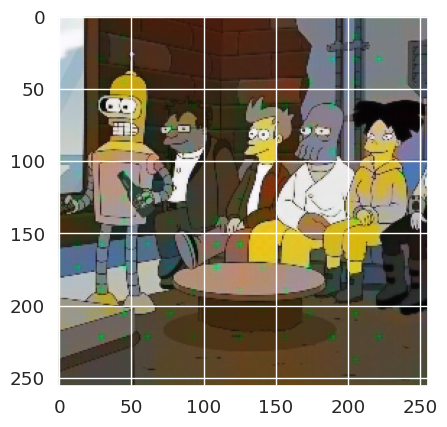

In [84]:
show_some_exampless(ff2) # сгенерированные

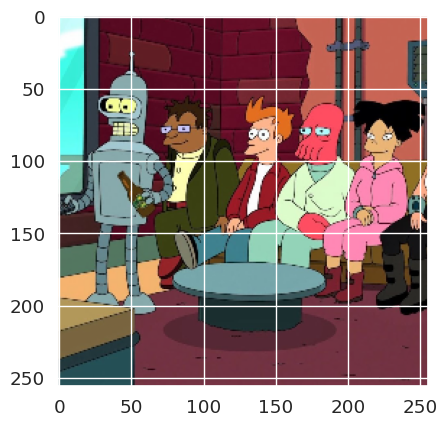

In [85]:
show_some_exampless(ff3) # из датасета с измененными размерами

In [ ]:
# получилось довольно забавно )